In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from data_loading import get_movielens_data
from evaluation import evaluate_policy
from policies.bcmabrp import BCMABRP
from policies.cbrap import CBRAP
from policies.linucb import LinUCB
from policies.linear_ts import LinearTS
from policies.d_lin_ts import DLinTS
from policies.random import RandomPolicy
from policies.egreedy import EGreedy
from reduct_matrix import get_reduct_matrix

from sklearn.model_selection import train_test_split

In [4]:
# Reproducibility
seed = 42
np.random.seed(seed)

In [5]:
dataset = get_movielens_data()

In [6]:
red_dim = 24
reduct_matrix = get_reduct_matrix("movielens", red_dim, load_old_reduct_matrix=False)

In [7]:
times = 10000

In [8]:
def plot_ctrs(reward_dict):
    fig, ax = plt.subplots(1,1, figsize=(15, 7));
    
    N = 10
    
    reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    for label, reward in reward_list:
        times = (range(1, len(reward)+1))
        ctr = [r/t for r,t in zip(reward, times)]
        ax.plot(ctr[N:], label=label)
        
    ax.set_xlabel('Trial')
    ax.set_ylabel('CTR')
    ax.set_title('CTR on MovieLens')

    plt.legend();
    plt.show();

In [9]:
def plot_ndcg(cumulative_ndcg_dict):
    fig, ax = plt.subplots(1,1, figsize=(15, 7));
    
    N = 10
    
    cumulative_ndcg_list = sorted(
        [
            (l,r) for l, r in cumulative_ndcg_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    for label, cumulative_ndcg in cumulative_ndcg_list:
        times = (range(1, len(cumulative_ndcg)+1))
        average_cumulative_ndcg = [cn/t for cn,t in zip(cumulative_ndcg, times)]
        ax.plot(average_cumulative_ndcg[N:], label=label)
        
    ax.set_xlabel('Trial')
    ax.set_ylabel('Average Cumulative NDCG@5')
    ax.set_title('Average Cumulative NDCG@5 on MovieLens')

    plt.legend();
    plt.show();

### Define policies

In [10]:
total_start_ts = time.time()

In [11]:
ctx_dim = 120


policies = {
#     'BCMABRP': BCMABRP(context_dimension=ctx_dim, red_dim=red_dim, reduct_matrix=reduct_matrix, nu=0.65, seed=seed),
#     'CBRAP': CBRAP(context_dimension=ctx_dim, red_dim=red_dim, reduct_matrix=reduct_matrix, alpha=0.5),
    'EGreedy': EGreedy(epsilon=0.6),
    'DLinTS': DLinTS(context_dimension=ctx_dim, gamma=0.999, a=0.2,  seed=seed),
    'LinearTS': LinearTS(context_dimension=ctx_dim, nu=0.2, seed=seed),
#     'LinUCB': LinUCB(context_dimension=ctx_dim, alpha=0.5),
    'Random': RandomPolicy(),
}

#### Introduce nonstationarity

In [12]:
def nonstationarity_function(trial, arm):
    """Takes trial and arm index as input and returns index of arm with which to swap."""
#     if 1000 < trial <= 2000:
#         return (arm + 250) % 1000

    if int(times/2) < trial <= times:
        return (arm + 500) % 1000
    else:
        return arm
    
#     return arm

#### Check nonstationarity

In [13]:
reward_vecs = np.zeros((times, 1000))
users = dataset.generate_users(times, tune=False)

for i, user_data in enumerate(users):
    context, reward_vector, score_true, missing_vector = user_data
    reward_vecs[i, :] = reward_vector

First user in exp from 2008-12-30 05:36:50
Last user in exp from 2009-01-05 05:52:22


In [14]:
nonst_reward_vecs = np.zeros(reward_vecs.shape)
for t in range(reward_vecs.shape[0]):
    for a in range(reward_vecs.shape[1]):
        nonst_reward_vecs[t, a] = reward_vecs[t, nonstationarity_function(t, a)]

In [15]:
reward_vecs

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

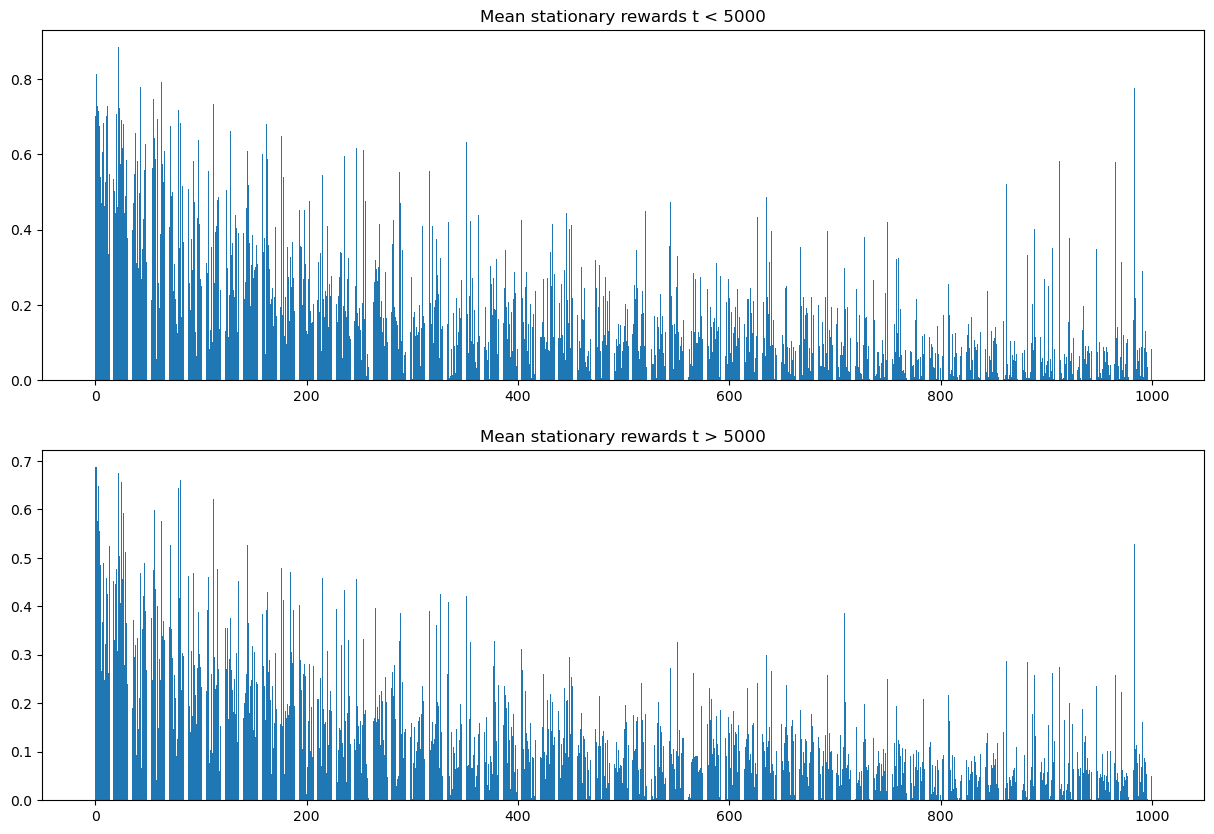

In [16]:
fig, axs = plt.subplots(2,1, figsize=(15, 10))
axs[0].bar(list(range(1000,)), np.mean(reward_vecs[:int(times/2)], axis=0))
axs[0].set_title(f'Mean stationary rewards t < {int(times/2)}')

axs[1].bar(list(range(1000,)), np.mean(reward_vecs[int(times/2):], axis=0))
axs[1].set_title(f'Mean stationary rewards t > {int(times/2)}')
plt.show()

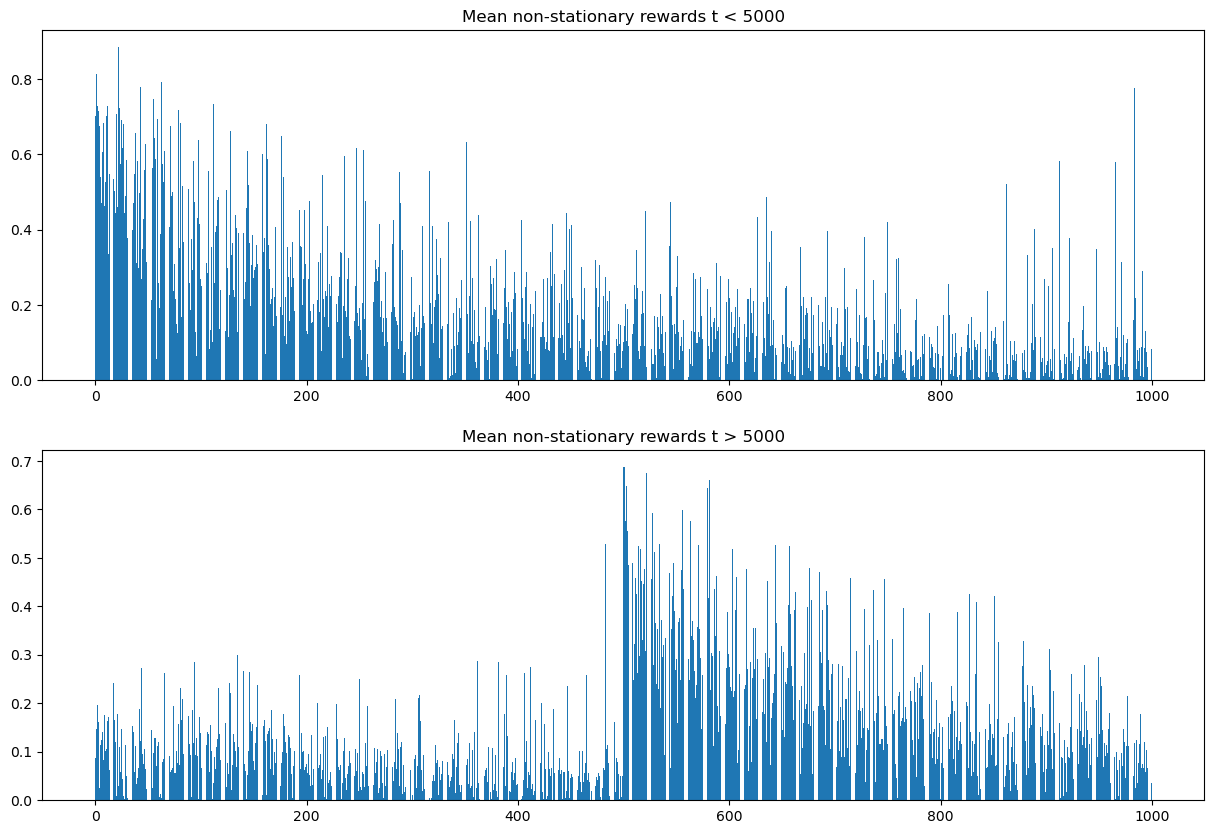

In [17]:
fig, axs = plt.subplots(2,1, figsize=(15, 10))
axs[0].bar(list(range(1000,)), np.mean(nonst_reward_vecs[:(int(times/2))], axis=0))
axs[0].set_title(f'Mean non-stationary rewards t < {int(times/2)}')

axs[1].bar(list(range(1000,)), np.mean(nonst_reward_vecs[(int(times/2)):], axis=0))
axs[1].set_title(f'Mean non-stationary rewards t > {int(times/2)}')
plt.show()

### Run evaluation

In [18]:
results = {'reward': {}, 'ndcg': {}}
for p_name, policy in policies.items():
    start_ts = time.time()

    reward, ndcg = evaluate_policy(policy, times, dataset, nonstationarity_function)
    results['reward'][p_name] = reward
    results['ndcg'][p_name] = ndcg
    print(f"Total reward of {p_name} is {reward[-1][0]}")
    print(f"Total time of {p_name} is {datetime.timedelta(seconds=time.time() - start_ts)}")

Using tuning dataset
First user in exp from 2008-10-30 01:45:56
Last user in exp from 2008-10-31 23:45:28
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
Total reward of EGreedy is 4377.0
Total time of EGreedy is 0:00:36.792142
Using tuning dataset
First user in exp from 2008-10-30 01:45:56
Last user in exp from 2008-10-31 23:45:28
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
Total reward of DLinTS is 7500.0
Total time of DLinTS is 0:03:40.732679
Using tuning dataset
First user in exp from 2008-10-30 01:45:56
Last user in exp from 2008-10-31 23:45:28
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
Total reward of LinearTS is 6033.0
Total time of LinearTS is 0:01:53.102600
Using tuning dataset
First user in exp from 2008-10-30 01:45:56
Last user in exp from 2008-10-31 23:45:28
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500


### Plot results

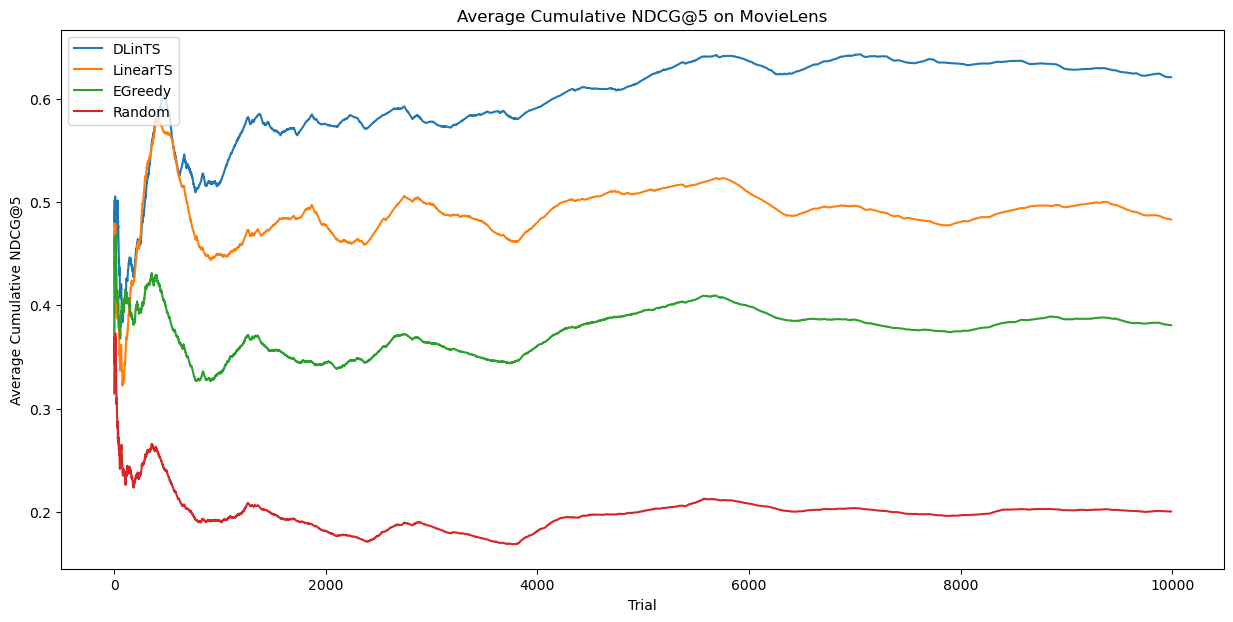

In [19]:
plot_ndcg(results['ndcg'])

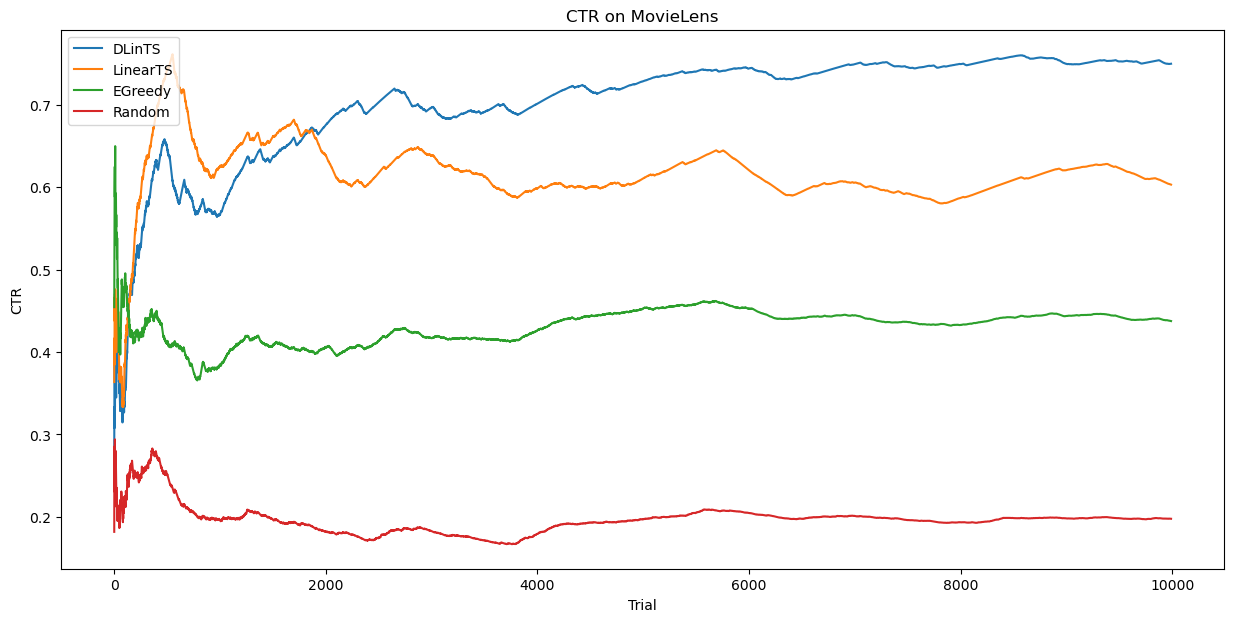

In [20]:
plot_ctrs(results['reward'])

In [21]:
print(f"Total time is {datetime.timedelta(seconds=time.time() - total_start_ts)}")

Total time is 0:07:22.928361
